In [2]:
import nltk
import os
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# Download Punkt Tokenizer Models if needed
nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/local/nltk_data')
nltk.download('stopwords', download_dir='/usr/local/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/nltk_data')

# Add the NLTK data path to the search path.
nltk.data.path.append("/usr/local/nltk_data")



# 读取数据
df = pd.read_csv("/content/cleaned_data.csv")


# 过滤非空 Description
df = df.dropna(subset=["Description"])

# 预处理函数
def preprocess_text(text):
    text = text.lower()  # 转小写
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # 去除特殊字符
    tokens = word_tokenize(text)  # 分词
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # 去除停用词
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]  # 词干化
    return " ".join(tokens)

# 应用预处理
df["ProcessedDescription"] = df["Description"].apply(preprocess_text)

# 显示前几行
df[["Description", "ProcessedDescription"]].head()

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/local/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Description,ProcessedDescription
0,WHITE HANGING HEART T-LIGHT HOLDER,white hang heart tlight holder
1,WHITE METAL LANTERN,white metal lantern
2,CREAM CUPID HEARTS COAT HANGER,cream cupid heart coat hanger
3,KNITTED UNION FLAG HOT WATER BOTTLE,knit union flag hot water bottl
4,RED WOOLLY HOTTIE WHITE HEART.,red woolli hotti white heart


正在计算 K=2 ...
正在计算 K=3 ...
正在计算 K=4 ...
正在计算 K=5 ...
正在计算 K=6 ...
正在计算 K=7 ...
正在计算 K=8 ...
正在计算 K=9 ...


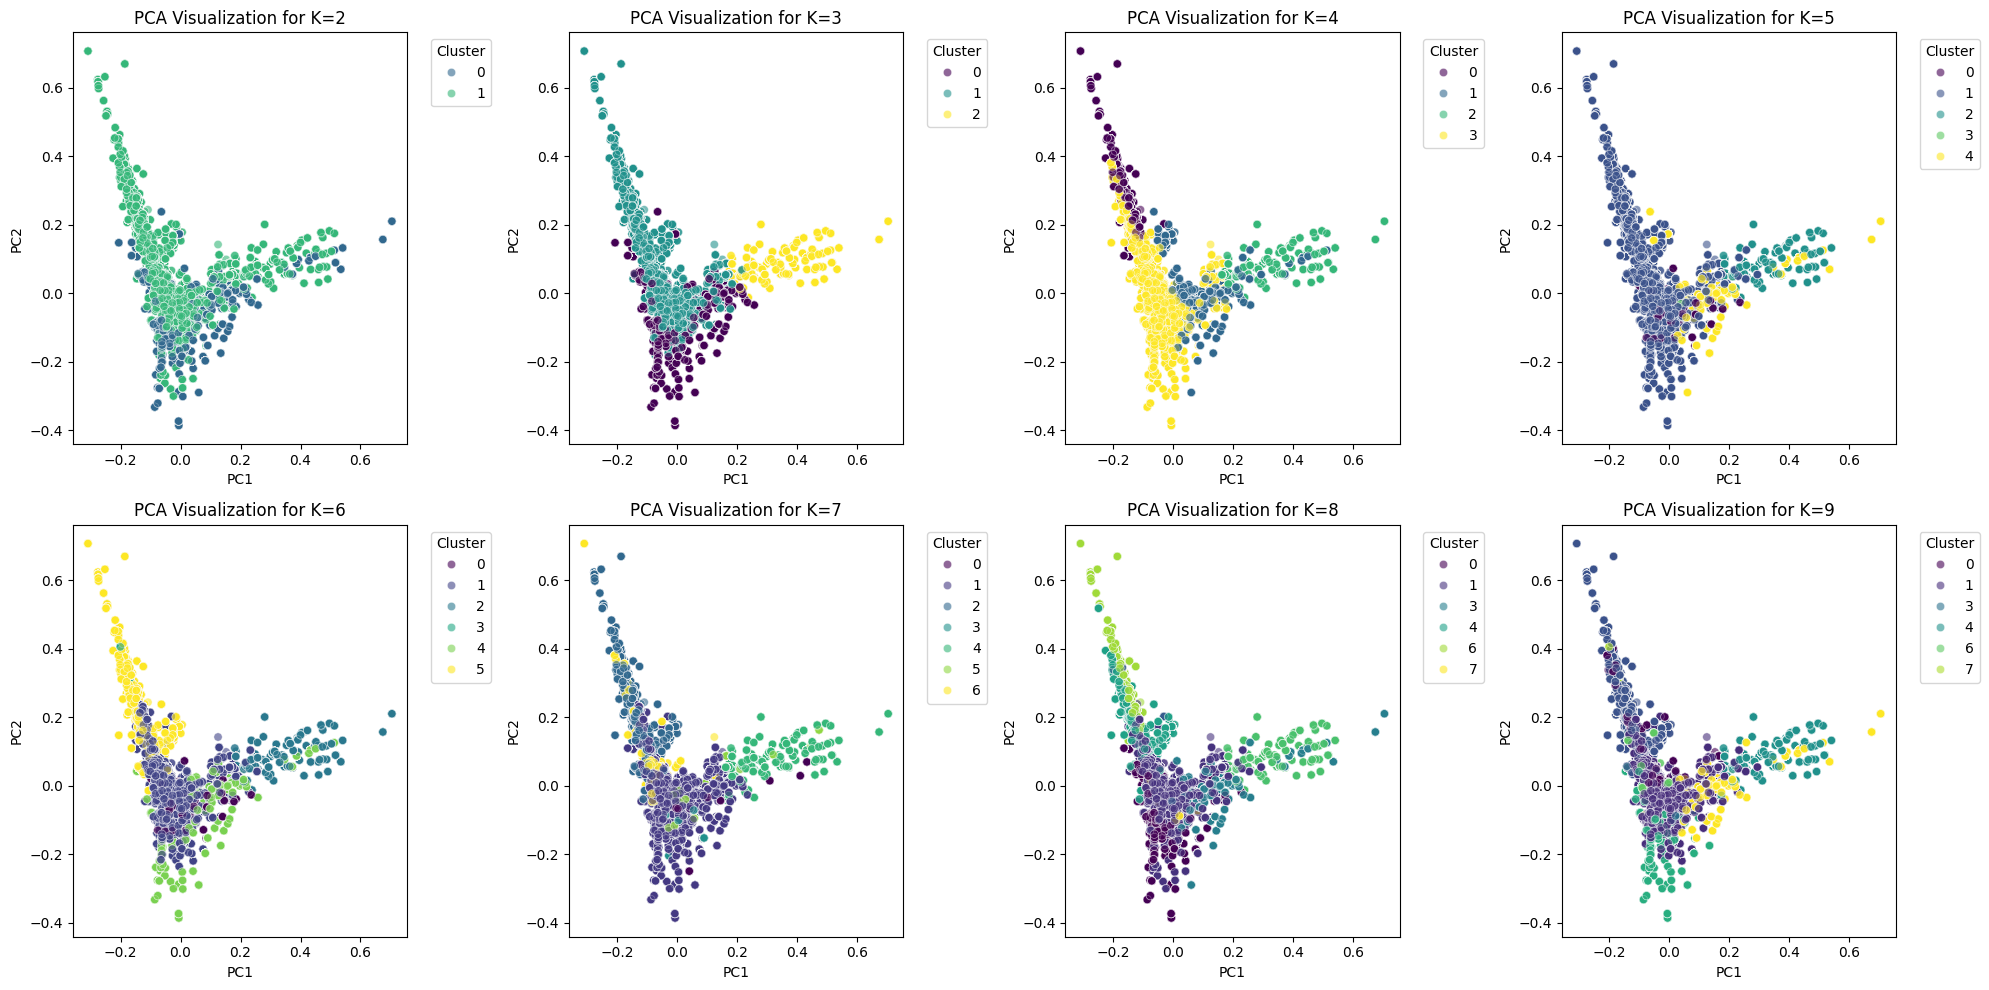

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 计算 TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df["ProcessedDescription"])

# 设置 K 值范围
K_range = range(2, 10)

# 存储 SSE 和 Silhouette Score
sse = []
silhouette_scores = []

# 逐个 K 值进行聚类并绘制 PCA 降维图
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 创建 2 行 4 列的子图
axes = axes.flatten()  # 将子图对象展平，方便索引

for i, k in enumerate(K_range):
    print(f"正在计算 K={k} ...")

    # MiniBatchKMeans 进行聚类
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=100)
    labels = kmeans.fit_predict(X_tfidf)

    # 计算 SSE 和 Silhouette Score
    sse.append(kmeans.inertia_)
    sample_size = min(5000, X_tfidf.shape[0])
    silhouette_scores.append(silhouette_score(X_tfidf[:sample_size], labels[:sample_size]))

    # PCA 降维
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # 创建 DataFrame 进行可视化
    df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    df_pca["Cluster"] = labels

    # 绘制 PCA 聚类散点图
    sns.scatterplot(ax=axes[i], x="PC1", y="PC2", hue="Cluster", palette="viridis", data=df_pca, alpha=0.6)
    axes[i].set_title(f"PCA Visualization for K={k}")
    axes[i].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整子图间距
plt.tight_layout()
plt.show()


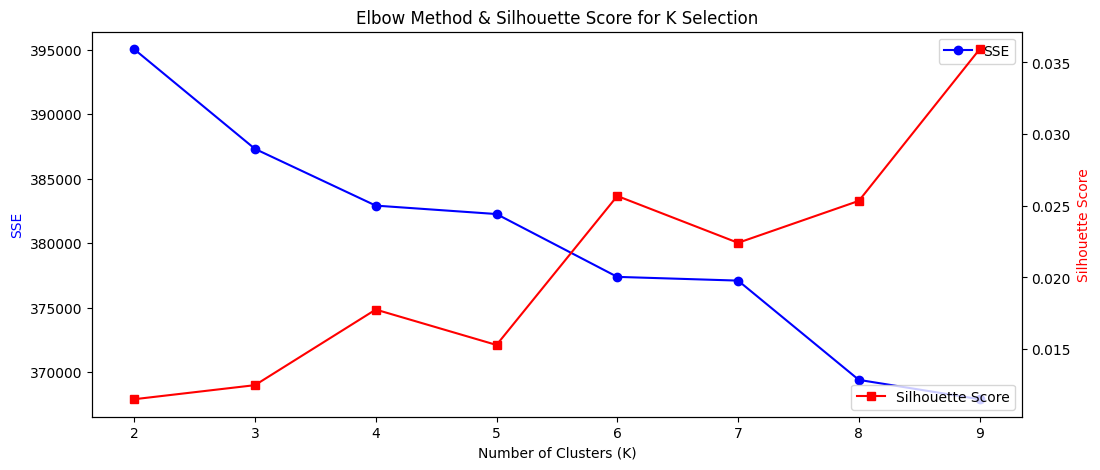

In [4]:
# **绘制 Elbow Method & Silhouette Score**
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

ax1.plot(K_range, sse, marker='o', linestyle='-', color='b', label='SSE')
ax2.plot(K_range, silhouette_scores, marker='s', linestyle='-', color='r', label='Silhouette Score')

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE", color='b')
ax2.set_ylabel("Silhouette Score", color='r')
ax1.set_title("Elbow Method & Silhouette Score for K Selection")

ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

plt.show()

In [5]:
# **选择最佳 K 进行 MiniBatchKMeans 聚类**
optimal_k = 6
print(f"✅ 选择的最佳 K 值: {optimal_k}")

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=100)
df["ProductCluster"] = kmeans.fit_predict(X_tfidf)

# **显示商品分类**
print(df[["Description", "ProductCluster"]].head(10))

# **保存聚类结果**
df.to_csv("/content/clustered_products.csv", index=False)
print("✅ 商品聚类完成，结果已保存到 clustered_products.csv")

✅ 选择的最佳 K 值: 6
                           Description  ProductCluster
0   WHITE HANGING HEART T-LIGHT HOLDER               5
1                  WHITE METAL LANTERN               1
2       CREAM CUPID HEARTS COAT HANGER               5
3  KNITTED UNION FLAG HOT WATER BOTTLE               1
4       RED WOOLLY HOTTIE WHITE HEART.               5
5         SET 7 BABUSHKA NESTING BOXES               0
6    GLASS STAR FROSTED T-LIGHT HOLDER               5
7               HAND WARMER UNION JACK               1
8            HAND WARMER RED POLKA DOT               1
9        ASSORTED COLOUR BIRD ORNAMENT               1
✅ 商品聚类完成，结果已保存到 clustered_products.csv


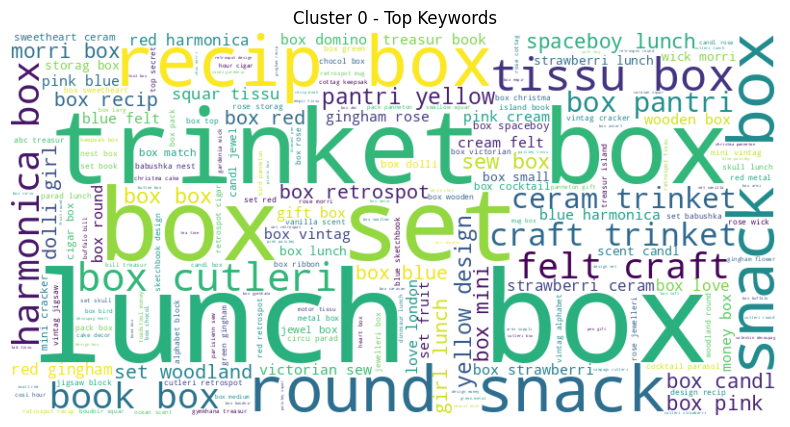

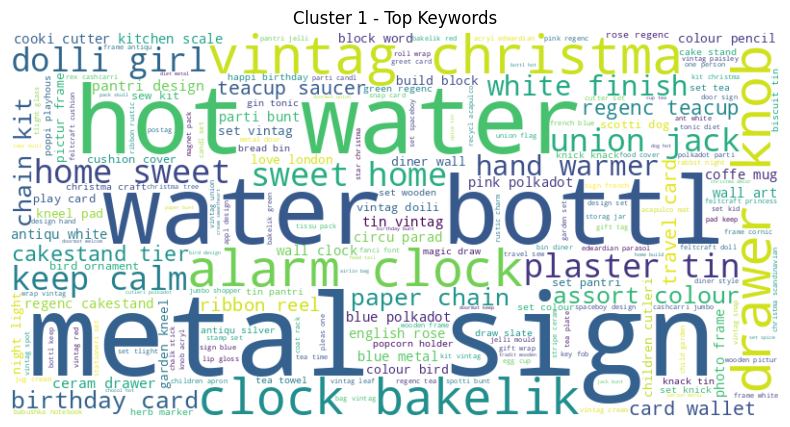

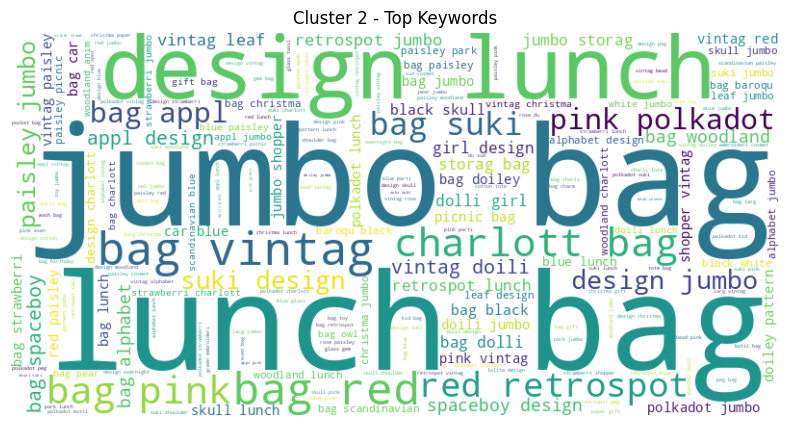

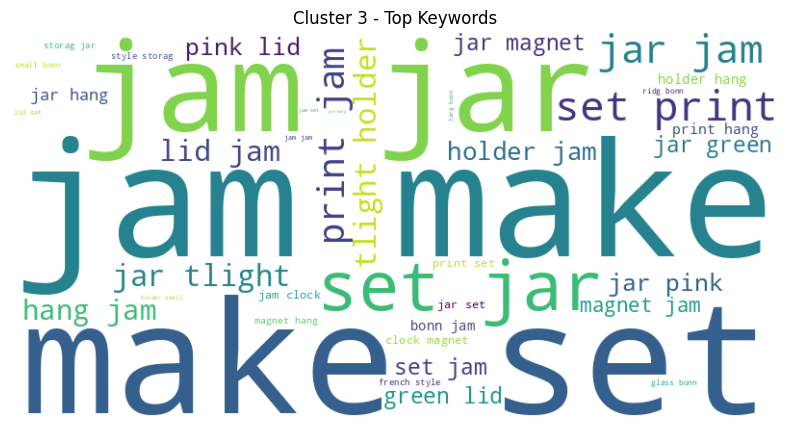

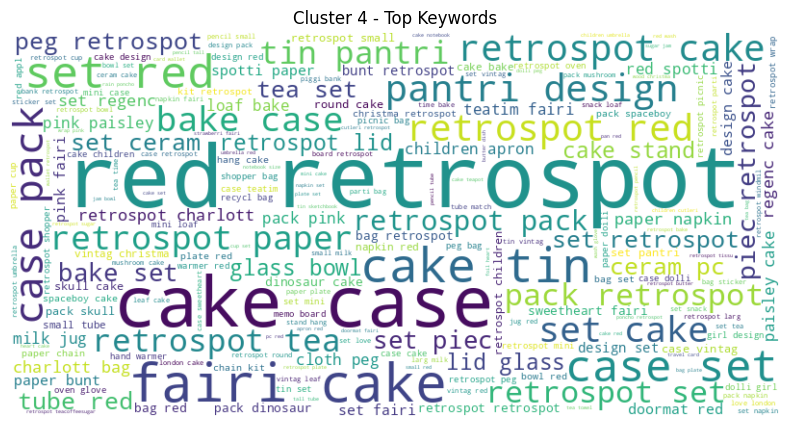

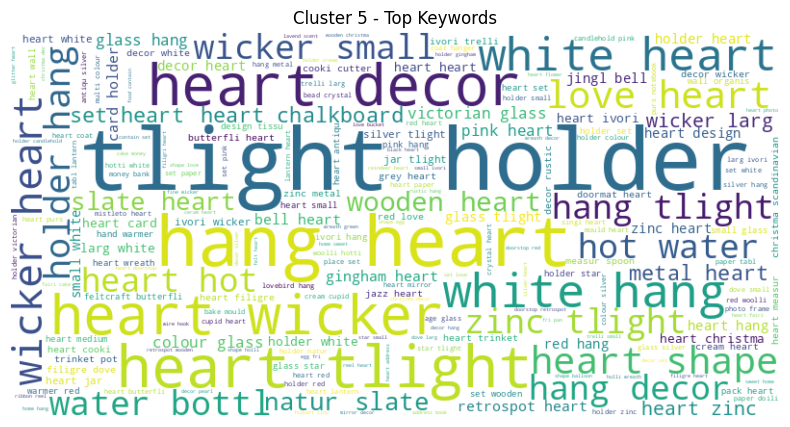

In [6]:
from wordcloud import WordCloud


# **绘制词云**
def plot_wordcloud(cluster_num):
    text = " ".join(df[df["ProductCluster"] == cluster_num]["ProcessedDescription"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} - Top Keywords")
    plt.show()

# **为每个类别生成词云**
for cluster in sorted(df["ProductCluster"].unique()):
    plot_wordcloud(cluster)
